In [17]:

import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('lyricsNew.csv')

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

def preprocess_lyrics(lyrics):
    if pd.isnull(lyrics):
        print('Lyrics are null')
        return ''
    # Convert to lower case
    lyrics = lyrics.lower()
    
    # Remove punctuation
    lyrics = re.sub(r'[^\w\s]', '', lyrics)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    lyrics = ' '.join([word for word in lyrics.split() if word not in stop_words])
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lyrics = ' '.join([lemmatizer.lemmatize(word) for word in lyrics.split()])
    
    return lyrics



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\godsk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# #remove Arjit Singh Lyrics songs
# df = df[df['artist'] != 'Arijit Singh Lyrics']
df['lyrics']

#print songs with null lyrics
len(df[df['lyrics'].isnull()]['song_name'])

# Drop rows with null lyrics
df = df.dropna(subset=['lyrics'])

#remove row if any of the column is null or empty or blank or nan
df = df.dropna()

#remove a row if that song name has remix in it
df = df[~df['song_name'].str.contains('remix', case=False)]

#remove a row if that song name has cover in it
df = df[~df['song_name'].str.contains('cover', case=False)]

In [19]:
df['preprocessed_lyrics'] = df['lyrics'].apply(preprocess_lyrics)

# Prepare the data for Doc2Vec
tagged_data = [TaggedDocument(words=word_tokenize(row['preprocessed_lyrics']), tags=[row['artist'] + '_' + row['song_name']]) for _, row in df.iterrows()]

# # Train the Doc2Vec model
model = Doc2Vec(tagged_data, vector_size=300, window=5, min_count=1, workers=16, epochs=10, dm=1)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)





In [ ]:
# from gensim.models import Doc2Vec
# from gensim.models.doc2vec import TaggedDocument
# from sklearn.base import BaseEstimator
# from sklearn.model_selection import GridSearchCV

# # Custom estimator class for Doc2Vec
# class Doc2VecEstimator(BaseEstimator):
#     def __init__(self, vector_size, window, min_count, dm, negative, workers):
#         self.vector_size = vector_size
#         self.window = window
#         self.min_count = min_count
#         self.dm = dm
#         self.negative = negative
#         self.workers = workers
#         self.model = None

#     def fit(self, X, y=None):
#         self.model = Doc2Vec(X, vector_size=self.vector_size, window=self.window,
#                              min_count=self.min_count, dm=self.dm,
#                              negative=self.negative,
#                              workers=self.workers)
#         self.model.build_vocab(X)
#         self.model.train(X, total_examples=self.model.corpus_count, epochs=10)
#         return self

#     def predict(self, X):
#         return [self.model.infer_vector(doc.words) for doc in X]

#     def score(self, X, y):
#         pass

# # Data preprocessing and preparation (omitted for brevity)
# ...

# # Hyperparameter tuning using GridSearchCV
# param_grid = {'vector_size': [100, 200, 300],
#               'window': [5, 10, 15],
#               'min_count': [1, 2, 5],
#               'dm': [1],
#               'negative': [5, 10, 15]
#               }

# doc2vec_estimator = Doc2VecEstimator(vector_size=100, window=5, min_count=1, dm=1,
#                                      negative=5, workers=4)
# grid_search = GridSearchCV(doc2vec_estimator, param_grid, cv=5, scoring='neg_root_mean_squared_log_error', verbose=1, n_jobs=-1)
# best_model = grid_search.fit(tagged_data)
# print(f"Best hyperparameters: {best_model.best_params_}")

In [736]:
model.save('trained_model')

model = Doc2Vec.load('trained_model')

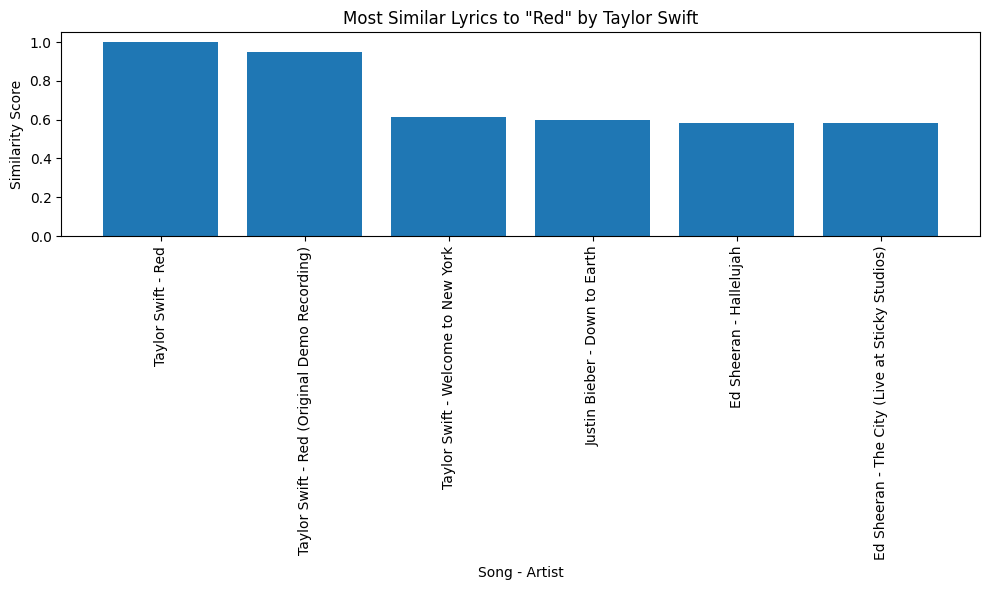

In [737]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def visualize_similar_lyrics(song_name, artist, k=5):
    # Get the document vector for the given song
    song_vector = model.docvecs[f"{artist}_{song_name}"]

    # Calculate the cosine similarity between the song vector and all other song vectors
    similarity_scores = model.docvecs.most_similar([song_vector], topn=k)

    # Plot the most similar songs
    plt.figure(figsize=(10, 6))
    plt.bar(range(k), [score[1] for score in similarity_scores])

    # Create the x-axis labels with artist and song name
    x_labels = []
    for score in similarity_scores:
        song = score[0].split('_')[1]
        rec_artist = score[0].split('_')[0]
        x_labels.append(f"{rec_artist} - {song}")

    plt.xticks(range(k), x_labels, rotation=90)
    plt.title(f'Most Similar Lyrics to "{song_name}" by {artist}')
    plt.xlabel('Song - Artist')
    plt.ylabel('Similarity Score')
    plt.tight_layout()
    plt.show()

visualize_similar_lyrics('Red', 'Taylor Swift', k=6)

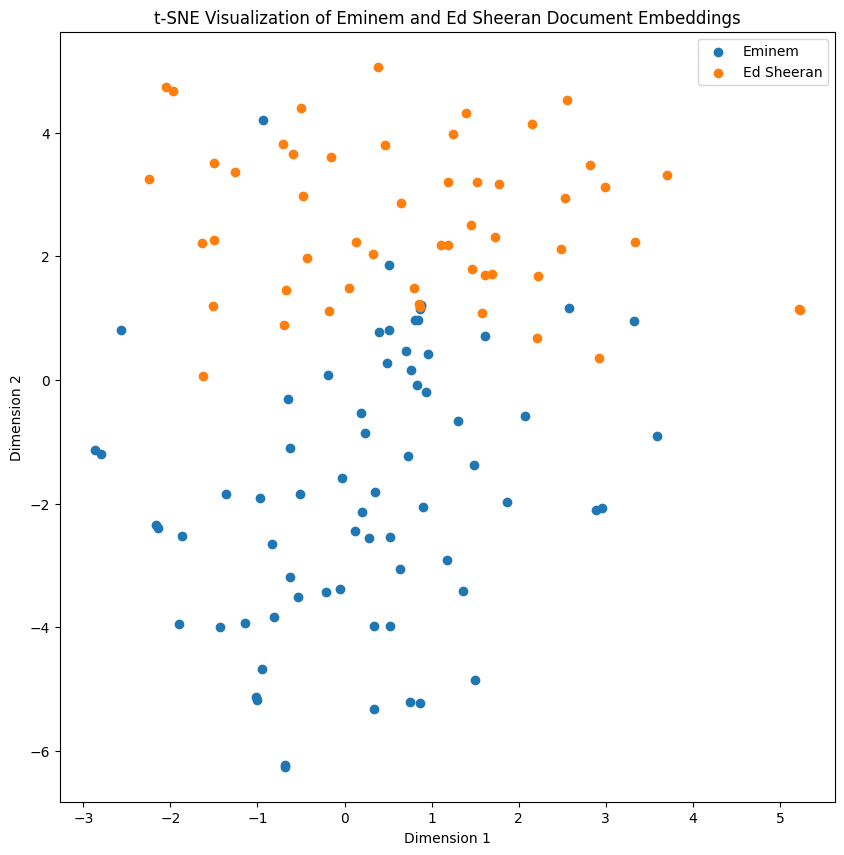

In [738]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Extract document embeddings for Billie Eilish and Drake
billie_eilish_docs = np.array([model.docvecs[f"Cardi B_{song_name}"] for song_name in df[df['artist'] == 'Cardi B']['song_name']])
drake_docs = np.array([model.docvecs[f"Khalid_{song_name}"] for song_name in df[df['artist'] == 'Khalid']['song_name']])

# Combine the document embeddings
all_docs = np.concatenate([billie_eilish_docs, drake_docs], axis=0)

# Reduce the dimensionality of the embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
all_docs_2d = tsne.fit_transform(all_docs)

# Plot the 2D embeddings
plt.figure(figsize=(10, 10))
plt.scatter(all_docs_2d[:len(billie_eilish_docs), 0], all_docs_2d[:len(billie_eilish_docs), 1], label='Eminem')
plt.scatter(all_docs_2d[len(billie_eilish_docs):, 0], all_docs_2d[len(billie_eilish_docs):, 1], label='Ed Sheeran')

# Add labels and legend
# for i, label in enumerate(df[(df['artist'] == 'Billie Eilish') | (df['artist'] == 'Drake')]['song_name']):
#     if i < len(billie_eilish_docs):
#         plt.annotate(label, (all_docs_2d[i, 0], all_docs_2d[i, 1]), fontsize=8)
#     else:
#         plt.annotate(label, (all_docs_2d[i, 0], all_docs_2d[i, 1]), fontsize=8)

plt.legend()
plt.title('t-SNE Visualization of Eminem and Ed Sheeran Document Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

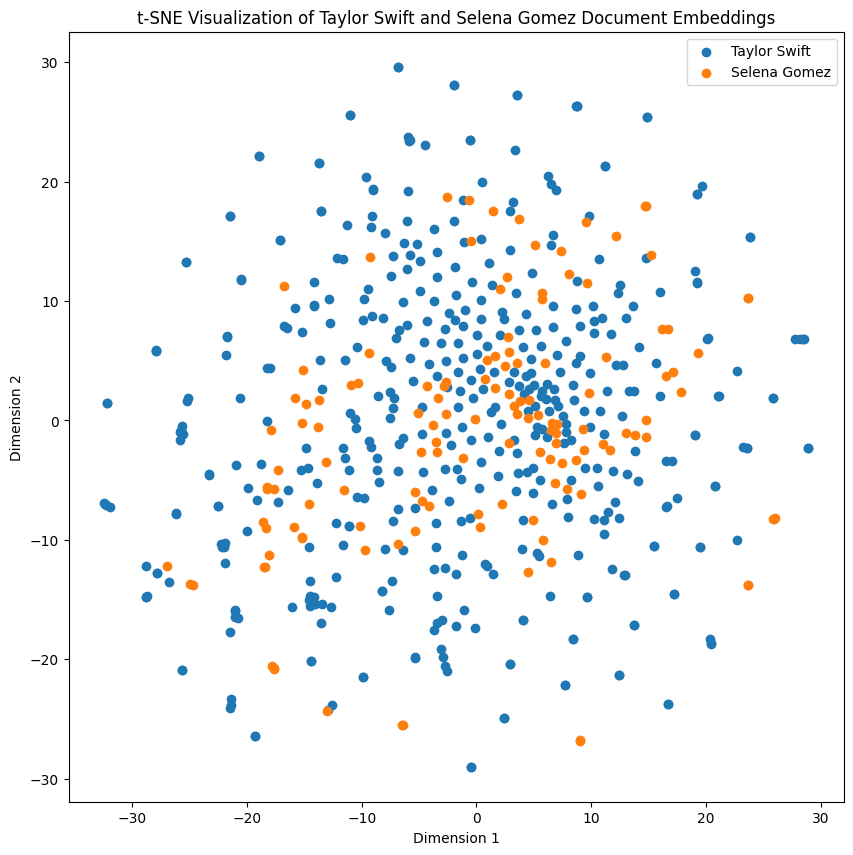

In [739]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Extract document embeddings for Billie Eilish and Drake
billie_eilish_docs = np.array([model.docvecs[f"Taylor Swift_{song_name}"] for song_name in df[df['artist'] == 'Taylor Swift']['song_name']])
drake_docs = np.array([model.docvecs[f"Selena Gomez_{song_name}"] for song_name in df[df['artist'] == 'Selena Gomez']['song_name']])

# Combine the document embeddings
all_docs = np.concatenate([billie_eilish_docs, drake_docs], axis=0)

# Reduce the dimensionality of the embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
all_docs_2d = tsne.fit_transform(all_docs)

# Plot the 2D embeddings
plt.figure(figsize=(10, 10))
plt.scatter(all_docs_2d[:len(billie_eilish_docs), 0], all_docs_2d[:len(billie_eilish_docs), 1], label='Taylor Swift')
plt.scatter(all_docs_2d[len(billie_eilish_docs):, 0], all_docs_2d[len(billie_eilish_docs):, 1], label='Selena Gomez')

# Add labels and legend
# for i, label in enumerate(df[(df['artist'] == 'Billie Eilish') | (df['artist'] == 'Drake')]['song_name']):
#     if i < len(billie_eilish_docs):
#         plt.annotate(label, (all_docs_2d[i, 0], all_docs_2d[i, 1]), fontsize=8)
#     else:
#         plt.annotate(label, (all_docs_2d[i, 0], all_docs_2d[i, 1]), fontsize=8)

plt.legend()
plt.title('t-SNE Visualization of Taylor Swift and Selena Gomez Document Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [740]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_songs_by_vibe(user_input, top_n=5):
    # Preprocess the user input
    user_input_preprocessed = preprocess_lyrics(user_input)

    # Get the document vector for the user input
    user_input_vector = model.infer_vector(user_input_preprocessed.split())

    # Calculate the cosine similarity between the user input and all song lyrics
    song_similarities = []
    for i, row in df.iterrows():
        song_vector = model.docvecs[f"{row['artist']}_{row['song_name']}"]
        similarity = cosine_similarity([user_input_vector], [song_vector])[0][0]
        song_similarities.append((row['artist'], row['song_name'], similarity))

    # Sort the songs by similarity and return the top n recommendations
    song_similarities.sort(key=lambda x: x[2], reverse=True)
    return song_similarities[:top_n]

# Example usage
user_input = "Live in the moment"
#suppress warnings
import warnings
warnings.filterwarnings("ignore")
print("User Input:", user_input)
recommendations = recommend_songs_by_vibe(user_input)
for artist, song_name, similarity in recommendations:
    print(f"{artist} - {song_name} (Similarity: {similarity:.2f})")


User Input: Live in the moment
Selena Gomez - Control mi (Similarity: 0.79)
Lady Gaga - Crystal Paint (Similarity: 0.78)
Rihanna - California King Bed (DJ Chus & Abel Ramos Dub) (Similarity: 0.77)
Coldplay - Colour Spectrum (Similarity: 0.77)
Rihanna - S&M (Dave Audé Dub) (Similarity: 0.77)


In [741]:
def recommend_similar_songs(artist, song_name, top_n=5):
    # Get the document vector for the input song
    song_vector = model.docvecs[f"{artist}_{song_name}"]

    # Calculate the cosine similarity between the input song and all other songs
    song_similarities = []
    for i, row in df.iterrows():
        other_song_vector = model.docvecs[f"{row['artist']}_{row['song_name']}"]
        similarity = cosine_similarity([song_vector], [other_song_vector])[0][0]
        song_similarities.append((row['artist'], row['song_name'], similarity))

    # Sort the songs by similarity and return the top n recommendations
    song_similarities.sort(key=lambda x: x[2], reverse=True)
    return song_similarities[1:top_n + 1]  # Exclude the input song itself

# Example usage
artist = "Selena Gomez"
song_name = "Wolves"
recommendations = recommend_similar_songs(artist, song_name)
for rec_artist, rec_song_name, similarity in recommendations:
    print(f"{rec_artist} - {rec_song_name} (Similarity: {similarity:.2f})")

Khalid - Angels (Similarity: 0.53)
Eminem - Revival (Interlude) (Similarity: 0.52)
Coldplay - Lost! (Similarity: 0.52)
Ed Sheeran - Save Myself (Similarity: 0.51)
Selena Gomez - Revival (Similarity: 0.51)
